In [6]:
import os
import pandas
from nltk.corpus import stopwords
german_stop_words = stopwords.words('german')
alternate_umlaut_stops = ['moegt', 'zurueck', 'muesst', 'fuenftes', 'wuerde', 'koennen', 'wuerden', 'grossen', 'ueber',
                          'waere', 'haette', 'dermassen', 'fuer', 'fuenf', 'demgemaess', 'moeglich', 'muessen',
                          'waehrend', 'ueberhaupt', 'darueber', 'spaeter', 'grosse', 'grosses', 'haetten', 'dass',
                          'waehrenddessen', 'muss', 'koennte', 'duerft', 'natuerlich', 'zunaechst', 'frueher',
                          'fuenften', 'heisst', 'moegen', 'dafuer', 'grosser', 'fuenfter', 'demgemaess',
                          'moechte', 'ausserdem', 'ausser', 'uebrigens', 'demgegenueber', 'gegenueber', 'koennt',
                          'duerfen', 'waehrenddem', 'fuenfte', 'gross', 'wurde', 'konnte', 'mal', 'beim', 'wäre', 'nie',
                          'immer', 'mehr', 'schon', 'gut', 'gute', 'kein', 'keins', 'haette', 'waere']

german_stop_words.extend(alternate_umlaut_stops)


In [9]:
data_path = '../data/backup/reg_focus_train_data_with_LIWC.csv'

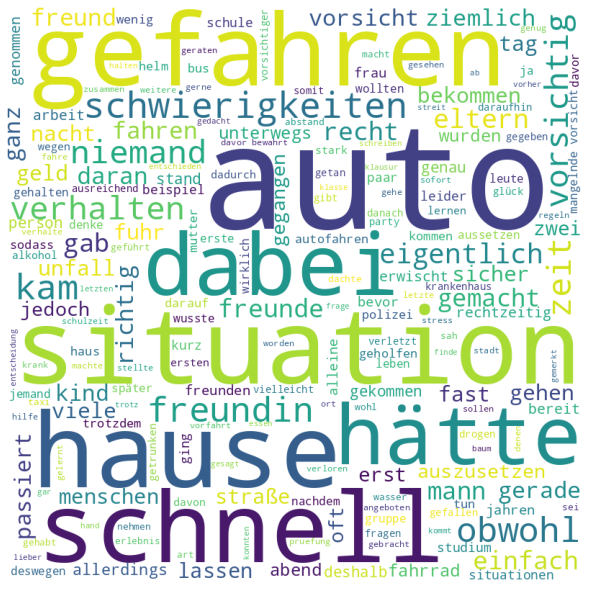

<Figure size 432x288 with 0 Axes>

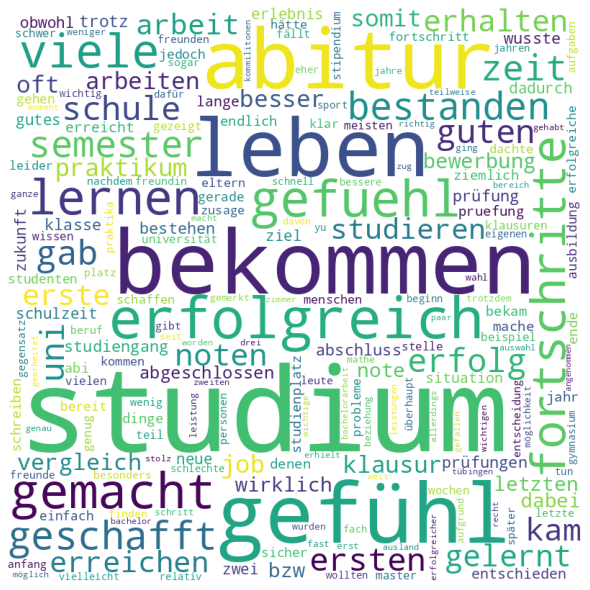

<Figure size 432x288 with 0 Axes>

In [13]:
# Python program to generate WordCloud

# importing all necessery modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv(data_path)

for foc in set(data.focus):
    df = data[data.focus == foc]
    comment_words = ''
    stopwords = set(german_stop_words)

    for val in df.text:
        val = str(val).lower()

        # split the value
        tokens = val.split()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image                    
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    plt.savefig(foc+'.svg')

In [ ]:
import pickle
#with open('../output/bert_results_16_05.pkl', 'rb') as f:
#    aggregate_result= pickle.load(f)
with open('../output/lexical_results_16_05.pkl', 'rb') as f:
    aggregate_result= pickle.load(f)


In [ ]:
for res in aggregate_result:
    if res.mode == 'holdout':
        print(res.ref)
        print(res.classification_report)
        print('############################')

In [ ]:
import pandas as pd
data_path = '/media/worte100/lottery/PhD/code/RFT_data_analysis/data/'
train_data_actual = data_path + 'reg_focus_train_data_with_topic_lex.csv'
holdout_data_actual = data_path + 'reg_focus_holdout_data_lex.csv'

LIWC_old_train = data_path+'/backup/reg_focus_train_data_with_LIWC.csv'
LIWC_old_holdout =  data_path+ '/backup/reg_focus_holdout_data_with_LIWC.csv'

def get_filtered_data(data):
    data = data[data.focus != 'unknown']
    lab = [l if l in [1, 2] else l - 2 for l in data['focus_id']]
    data['focus_id'] = lab
    data['label'] = data['focus_id'] - 1
    data['len'] = data.text.apply(str).apply(len)
    data = data[data.len > 3]
    cols = [c for c in data.columns if c not in ['len', 'nan']]
    return data[cols]

In [ ]:
merged_LIWC = pd.concat([pd.read_csv(LIWC_old_train), pd.read_csv(LIWC_old_holdout)])
merged_LIWC.head()

In [ ]:
train_data = get_filtered_data(pd.read_csv(train_data_actual))
holdout_data = get_filtered_data(pd.read_csv(holdout_data_actual))
len(train_data) + len(holdout_data)

In [ ]:
new_train_LIWC = pd.merge(train_data, merged_LIWC, on="text", how = 'inner')
new_holdout_LIWC = pd.merge(holdout_data, merged_LIWC, on="text", how = 'inner')

x_files = [f for f in new_holdout_LIWC.columns if '_x' in f]
y_files = [f for f in new_holdout_LIWC.columns if '_y' in f]
for x,y in zip(x_files, y_files):
    assert list(new_holdout_LIWC[x]) == list(new_holdout_LIWC[y])

# remove y_files
# rename x_files
new_name_dict = {x:x.replace('_x','') for x in x_files}
unnamed = [f for f in new_holdout_LIWC.columns if 'Unnamed'in f]

new_holdout_LIWC = new_holdout_LIWC.drop(y_files + unnamed, axis = 1)
new_holdout_LIWC = new_holdout_LIWC.rename(columns = new_name_dict)
new_train_LIWC = new_train_LIWC.drop(y_files+unnamed, axis = 1)
new_train_LIWC = new_train_LIWC.rename(columns = new_name_dict)


In [ ]:
new_train_LIWC.to_csv(data_path + 'train_LIWC.csv')
new_holdout_LIWC.to_csv(data_path + 'holdout_LIWC.csv')

In [ ]:
data_path

In [ ]:
def get_score(d):
    files = {'showAllScore': (None, 'true'),
                     'text': (None, str(d)),
                     'lang' : (None,'de'),}

    response = requests.post(url,files=files)
    response_dict = response.json()
    score_dict = response_dict['score']
    score_dict = {k:v for k,v in score_dict.items()}
    score_dict['wordCount'] = response_dict['wordCount']
    score_dict['text'] = d
    score_dict['a_text'] = d
    return score_dict
    
import requests
import progressbar

fnames_100W = ['train_100W.csv', 'holdout_100W.csv']
for ii,datax in enumerate([train_data, holdout_data]):
    score_list = [get_score(d) for d in datax.text]
    assert len(score_list) == len(datax.text)
    x = pd.DataFrame(score_list)
    print(len(x), len(datax))
    x = pd.merge(datax, x, on= 'text')
    print('Wrting to scores.csv')
    x.to_csv(data_path+ fnames_100W[ii])
    print('Done !!!!')

In [ ]:
x[['reward','risk']]

In [ ]:
x[['a_text','text']]